In [237]:
import pandas as pd
import seaborn as sns
import numpy as np
import glob
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
sns.set_context("notebook", font_scale=1.25)

In [108]:
def parse_gtime(filename):
    """
    Parses a gtime output file to extract elapsed time and maximum memory usage.

    Args:
        filename (str): Path to the gtime output file.

    Returns:
        tuple: A tuple containing:
               - time (str): Elapsed wall clock time in the format "h:mm:ss" or "m:ss".
               - memory (int): Maximum resident set size in kilobytes.
    """

    def convert_to_seconds(time_str):
        """
        Converts a time string in the format "h:mm:ss" or "m:ss" to seconds.
    
        Args:
            time_str (str): Time string in "h:mm:ss" or "m:ss" format.
    
        Returns:
            float: Time in seconds.
        """
        parts = time_str.split(":")
        if len(parts) == 3:  # Format: h:mm:ss
            hours, minutes, seconds = map(float, parts)
            return hours * 3600 + minutes * 60 + seconds
        elif len(parts) == 2:  # Format: m:ss
            minutes, seconds = map(float, parts)
            return minutes * 60 + seconds
        elif len(parts) == 1: # just seconds
            return float(parts[0])
        else:
            raise ValueError(f"Unrecognized time format: {time_str}")
            
    time = None
    memory = None

    with open(filename, 'r') as file:
        for line in file:
            # Extract elapsed time
            if line.strip().startswith("Elapsed (wall clock) time"):
                time_str = line.strip().strip("Elapsed (wall clock) time (h:mm:ss or m:ss):")
                time = convert_to_seconds(time_str)

            # Extract maximum memory usage
            if line.strip().startswith("Maximum resident set size"):
                memory = int(line.split(":")[-1].strip())

    return time, memory

In [136]:
def parse_number_of_mutations(filename):
    with open(filename, "r") as f:
        s = f.readline().split("\t")
        pi_vec = [ss for ss in s if ss.startswith('pi_')]
        return len(pi_vec)

In [247]:
# handle infer_full_trees experiments
rows = []
for filename in glob.glob("../data/sims/*.tsv"):
    basename = os.path.basename(filename).rstrip(".tsv")
    s = basename.split('_')
    n = int(s[0][1:])
    if n == 8: continue
    m = int(s[1][1:])
    seed = int(s[2][1:])

    for tau in [1,5,10,20,50]:
        time, memory = parse_gtime("sims_tau_cvxopt_small_expand/" + basename + "_t" + str(tau) + ".time.txt")
        row = {'n' : n, 'm' : m, 'seed' : seed, 'tau' : tau, 'time' : time, 'memory' : memory, 'method' : 'cvxopt-small'}
        rows.append(row)

        time, memory = parse_gtime("sims_tau_fastppm_small_expand/" + basename + "_t" + str(tau) + ".time.txt")
        S = parse_number_of_mutations("sims_tau_fastppm_small_expand/" + basename + "_t" + str(tau) + ".txt")
        row = {'|S|' : S, 'n' : n, 'm' : m, 'seed' : seed, 'tau' : tau, 'time' : time, 'memory' : memory, 'method' : 'fastppm-small'}
        rows.append(row)

        time, memory = parse_gtime("sims_tau_fastppm_big_expand/" + basename + "_t" + str(tau) + ".time.txt")
        S = parse_number_of_mutations("sims_tau_fastppm_big_expand/" + basename + "_t" + str(tau) + ".txt")
        row = {'|S|' : S, 'n' : n, 'm' : m, 'seed' : seed, 'tau' : tau, 'time' : time, 'memory' : memory, 'method' : 'fastppm-big'}
        rows.append(row)
        
df_full_trees = pd.DataFrame(rows)
df_full_trees['frac'] = df_full_trees['|S|']/n

In [254]:
df_full_trees[(df_full_trees['tau'] == 1) & (df_full_trees['n'] == 20) & (df_full_trees['method'] == 'fastppm-small')]['frac'].median()

np.float64(0.24)

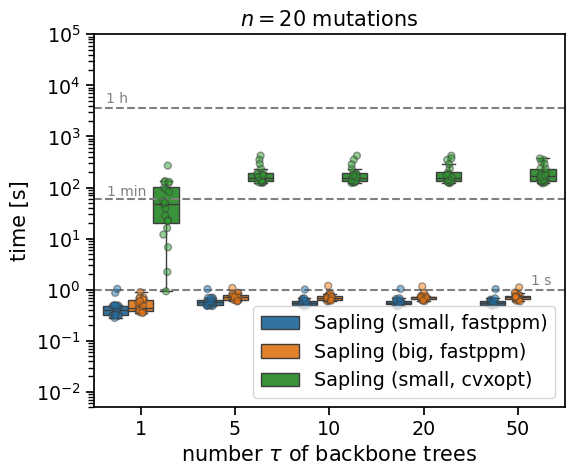

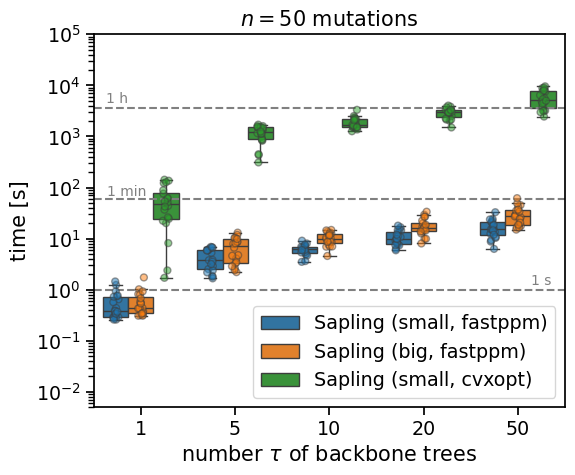

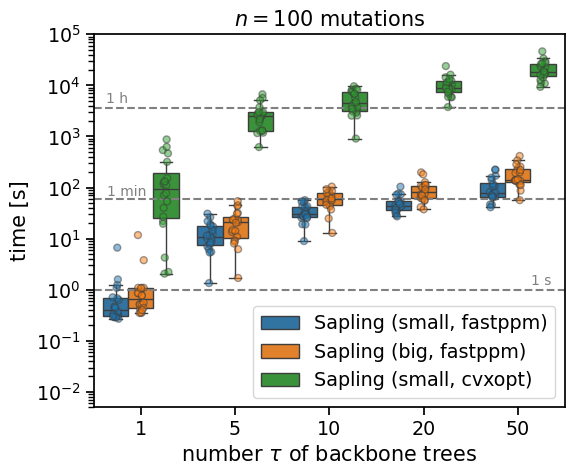

In [245]:
for n in [20, 50, 100]:
    df_tmp = df_full_trees[(df_full_trees["n"] == n)]
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.boxplot(data=df_tmp, ax=ax, x="tau", y="time", hue_order=['fastppm-small','fastppm-big','cvxopt-small'],
                hue="method", showfliers=False)
    sns.stripplot(data=df_tmp, ax=ax, x="tau", y="time", hue_order=['fastppm-small','fastppm-big','cvxopt-small'],
                  hue="method",dodge=True, alpha=.5, linewidth=1)
    ax.set_yscale("log")
    ax.set_ylabel("time [s]")
    ax.set_xlabel("number $\\tau$ of backbone trees")
    ax.set_title("$n=%d$ mutations" % n)
    ax.set_ylim((5e-3,1e5))
    handles, labels = ax.get_legend_handles_labels()
    labels[2] = "Sapling (small, cvxopt)"
    labels[0] = "Sapling (small, fastppm)"
    labels[1] = "Sapling (big, fastppm)"

    plt.axhline(y=3600, color='gray', linestyle='--')
    plt.text(x=-0.25, y=4000, s='1 h', color='gray', ha='center', va='bottom',fontsize='10')
    plt.axhline(y=1, color='gray', linestyle='--')
    plt.text(x=4.25, y=1.1, s='1 s', color='gray', ha='center', va='bottom',fontsize='10')
    plt.axhline(y=60, color='gray', linestyle='--')
    plt.text(x=-0.15, y=60.1, s='1 min', color='gray', ha='center', va='bottom',fontsize='10')
    
    plt.legend(handles[:3], labels[:3], loc='lower right')
    plt.tight_layout()
    plt.savefig("sapling_tau_n%d.pdf" % n)

/var/folders/_6/xs7jqx4d4_x084c61frqwsrr0000gn/T/ipykernel_38071/2941306515.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['frac'] = df_tmp['|S|']/n
/var/folders/_6/xs7jqx4d4_x084c61frqwsrr0000gn/T/ipykernel_38071/2941306515.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tmp['frac'] = df_tmp['|S|']/n
/var/folders/_6/xs7jqx4d4_x084c61frqwsrr0000gn/T/ipykernel_38071/2941306515.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[r

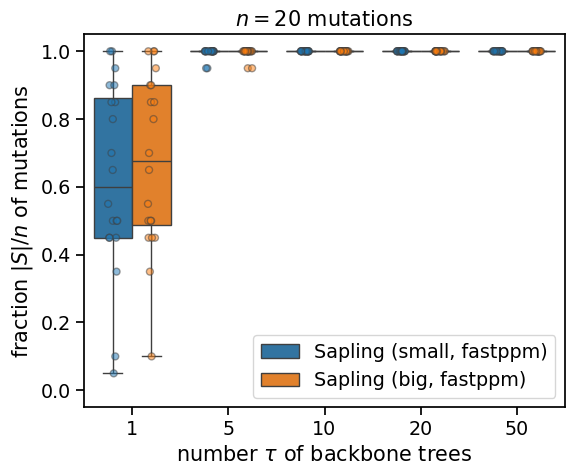

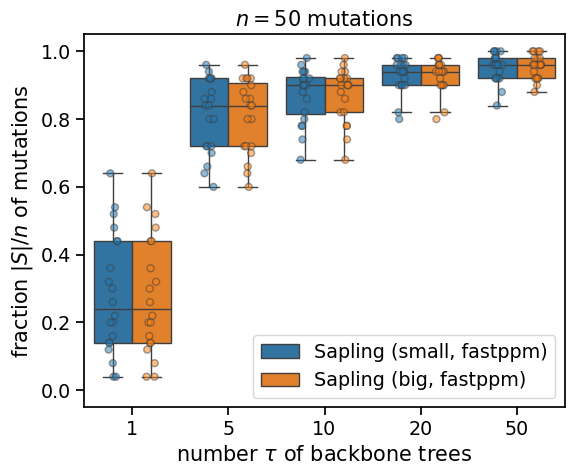

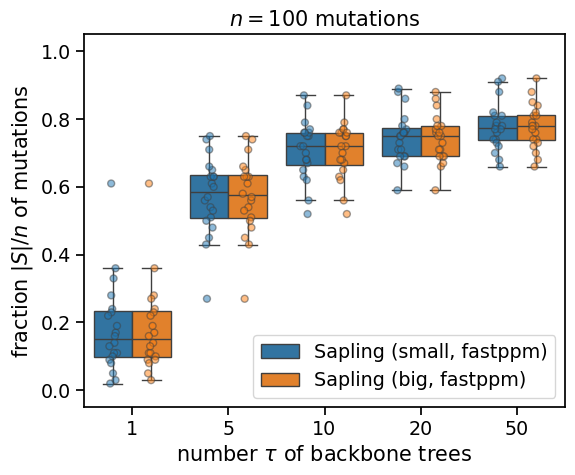

In [246]:
for n in [20, 50, 100]:
    df_tmp = df_full_trees[(df_full_trees["n"] == n) & ((df_full_trees["method"] == 'fastppm-small') | (df_full_trees["method"] == 'fastppm-big'))]
    df_tmp['frac'] = df_tmp['|S|']/n
    fig, ax = plt.subplots(figsize=(6, 5))
    sns.boxplot(data=df_tmp, hue='method',
                ax=ax, x="tau", y="frac", showfliers=False)
    sns.stripplot(data=df_tmp, hue='method', dodge=True,
                  ax=ax, x="tau", y="frac", alpha=.5, linewidth=1)
    # ax.set_yscale("log")
    ax.set_ylabel("fraction $|S|/n$ of mutations")
    ax.set_xlabel("number $\\tau$ of backbone trees")
    ax.set_title("$n=%d$ mutations" % n)
    ax.set_ylim((-0.05, 1.05))
    # if n==20:
        # ax.yaxis.set_major_locator(mpl.ticker.MultipleLocator(5))

    handles, labels = ax.get_legend_handles_labels()
    labels[0] = "Sapling (small, fastppm)"
    labels[1] = "Sapling (big, fastppm)"

    plt.legend(handles[:2], labels[:2], loc='lower right')
    
    plt.tight_layout()
    plt.savefig("sapling_S_n%d.pdf" % n)

In [2]:
def extract_matrices(input_file):
    """
    Extracts variant read count matrix (V) and total read count matrix (D) from a TSV file.

    Args:
        input_file (str): Path to the input TSV file.

    Returns:
        tuple: A tuple containing:
               - V (numpy.ndarray): A 2D array of variant read counts (samples x mutations).
               - D (numpy.ndarray): A 2D array of total read counts (samples x mutations).
    """
    # Read the TSV file into a DataFrame
    df = pd.read_csv(input_file, sep='\t')

    # Sort the DataFrame by sample_index and mutation_index
    df = df.sort_values(by=['sample_index', 'mutation_index'])

    # Pivot the DataFrame to create matrices
    V = df.pivot(index='sample_index', columns='mutation_index', values='var').values
    D = df.pivot(index='sample_index', columns='mutation_index', values='depth').values

    return V, D

In [18]:
import networkx as nx
import itertools
import fastppm  # Assuming fastppm is installed and available

# Parameters
n = 8  # Number of nodes
rho = 0.9  # Factor for filtering trees

# Step 1: Generate all labeled rooted trees with n=8 and root=0
def generate_rooted_trees(n):
    """Generate all labeled rooted trees with n nodes, where 0 is the root."""
    # Generate all possible edges (excluding self-loops)
    possible_edges = list(itertools.combinations(range(n), 2))
    
    # Generate all possible trees using Prufer sequences
    prufer_sequences = itertools.product(range(n), repeat=n-2)
    
    trees = []
    for seq in tqdm(prufer_sequences, desc="Generating trees"):
        # Create tree from Prufer sequence
        edges = nx.from_prufer_sequence(seq)
        G = nx.Graph(edges)

        for root in range(n):
            # Root the tree at node root
            tree = nx.dfs_tree(G, source=root)
            parent_list = [-1] * n
            for (u,v) in tree.edges:
                parent_list[v] = u
            trees.append(parent_list)
    
    return trees

# Step 2: Compute log-likelihood for each tree
def compute_log_likelihoods(trees, filename):
    """Compute log-likelihood for each tree using fastppm.regress."""
    V, D = extract_matrices(filename)
    log_likelihoods = []
    for tree in tqdm(trees, desc=("Regressing %s" % filename)):
        adj_list = [[] for _ in range(len(tree))]
        for child, parent in enumerate(tree):
            if parent != -1:
                adj_list[parent].append(child)
        try:
            result = fastppm.regress_counts(adj_list, V, D)  # Call fastppm.regress
        except ValueError as e:
            print(e)
            print(tree, adj_list)
        llh = -result['objective']
        log_likelihoods.append((tree, llh))
    return log_likelihoods

# Step 3: Filter trees based on log-likelihood
def filter_trees(log_likelihoods, max_llh, log_rho):
    """Filter trees whose log-likelihood is within a factor of rho from the maximum."""
    llh_EPS = 1e-4
    threshold = max_llh + log_rho - llh_EPS
    filtered_trees = [(tree, llh) for tree, llh in log_likelihoods if llh >= threshold]
    return filtered_trees

In [8]:
trees = generate_rooted_trees(n)  # Generate all rooted trees

Generating trees: 0it [00:00, ?it/s]

In [19]:
log_rho = np.log(rho)
for filename in tqdm(glob.glob("../data/sims/n8*.tsv")):
    log_likelihoods = compute_log_likelihoods(trees, filename)  # Compute log-likelihoods   
    max_llh = max(llh for _, llh in log_likelihoods)
    
    filtered_trees = filter_trees(log_likelihoods, max_llh, log_rho)  # Filter trees
    with open("sims_tau_n8_ground_truth/" + os.path.basename(filename), "w") as f:
        f.write("llh\t" + "\t".join(["pi_" + str(i) for i in range(n)]) + "\n")
        for tree, llh in filtered_trees:
            f.write(str(llh) + "\t" + "\t".join(map(str, tree)) + "\n")

  0%|          | 0/20 [00:00<?, ?it/s]

Regressing ../data/sims/n8_m2_s19.tsv:   0%|          | 0/2097152 [00:00<?, ?it/s]

Regressing ../data/sims/n8_m2_s2.tsv:   0%|          | 0/2097152 [00:00<?, ?it/s]

Regressing ../data/sims/n8_m2_s3.tsv:   0%|          | 0/2097152 [00:00<?, ?it/s]

Regressing ../data/sims/n8_m2_s18.tsv:   0%|          | 0/2097152 [00:00<?, ?it/s]

Regressing ../data/sims/n8_m2_s1.tsv:   0%|          | 0/2097152 [00:00<?, ?it/s]

Regressing ../data/sims/n8_m2_s4.tsv:   0%|          | 0/2097152 [00:00<?, ?it/s]

Regressing ../data/sims/n8_m2_s5.tsv:   0%|          | 0/2097152 [00:00<?, ?it/s]

Regressing ../data/sims/n8_m2_s20.tsv:   0%|          | 0/2097152 [00:00<?, ?it/s]

Regressing ../data/sims/n8_m2_s7.tsv:   0%|          | 0/2097152 [00:00<?, ?it/s]

Regressing ../data/sims/n8_m2_s6.tsv:   0%|          | 0/2097152 [00:00<?, ?it/s]

Regressing ../data/sims/n8_m2_s10.tsv:   0%|          | 0/2097152 [00:00<?, ?it/s]

Regressing ../data/sims/n8_m2_s11.tsv:   0%|          | 0/2097152 [00:00<?, ?it/s]

Regressing ../data/sims/n8_m2_s13.tsv:   0%|          | 0/2097152 [00:00<?, ?it/s]

Regressing ../data/sims/n8_m2_s8.tsv:   0%|          | 0/2097152 [00:00<?, ?it/s]

Regressing ../data/sims/n8_m2_s9.tsv:   0%|          | 0/2097152 [00:00<?, ?it/s]

Regressing ../data/sims/n8_m2_s12.tsv:   0%|          | 0/2097152 [00:00<?, ?it/s]

Regressing ../data/sims/n8_m2_s16.tsv:   0%|          | 0/2097152 [00:00<?, ?it/s]

Regressing ../data/sims/n8_m2_s17.tsv:   0%|          | 0/2097152 [00:00<?, ?it/s]

Regressing ../data/sims/n8_m2_s15.tsv:   0%|          | 0/2097152 [00:00<?, ?it/s]

Regressing ../data/sims/n8_m2_s14.tsv:   0%|          | 0/2097152 [00:00<?, ?it/s]

In [30]:
n=8
GT_trees_per_filename = {}
for filename in glob.glob("sims_tau_n8_ground_truth/*.tsv"):
    GT_trees = []
    with open(filename, "r") as f:
        f.readline()
        for line in f:
            s = line.rstrip("\n").split("\t")
            llh = s[0]
            parent_list = list(map(int,s[1:]))

            GT_trees.append(parent_list)
    GT_trees_per_filename[filename] = GT_trees

In [31]:
import itertools
from collections import defaultdict
import networkx as nx

def determine_min_backbone_trees(GT_trees, n, ell):
    """
    Determine the minimum backbone trees by evaluating all combinations of size ell.
    
    Args:
        GT_trees (list): List of trees, where each tree is represented as an edge list.
        n (int): Total number of nodes.
        ell (int): Size of the subset to evaluate.
    
    Returns:
        list: List of combinations X that result in the smallest set of unique subsetted trees.
    """
    
    def contract_other_edges(G, nodes):
        # Create a copy of the graph to avoid modifying the original
        G_minor = G.copy()
        
        # Iterate over all edges in the graph
        for child, parent in enumerate(G_minor):
            # print(f"Examining ({parent}, {child}) given {nodes}... ",)
            if child not in nodes:
                G_minor[child] = None
                # print(f"{nodes} ;;; setting G_minor[{child}] = None,")
            elif parent not in nodes and parent != -1:
                grand_parent = parent
                while grand_parent not in nodes and grand_parent != -1:
                    grand_parent = G[grand_parent]
                G_minor[child] = grand_parent
                # print(f"setting G_minor[{child}] = {grand_parent},")
            # print()

        return G_minor
        
    # Generate all combinations of size ell from the set range(n)
    combinations = list(itertools.combinations(range(n), ell))
    
    # Initialize a dictionary to store the set of unique subsetted trees for each combination
    subset_counts = defaultdict(int)
    
    # Iterate over each combination X
    # combinations = [(1, 2, 3, 4, 5, 6)]
    # combinations = [(1,)]
    for idx, X in tqdm(enumerate(combinations)):
        unique_trees = set()
        
        # Iterate over each tree in GT_trees
        for tree in GT_trees:
            # print(X, tree)
            # Create a NetworkX graph from the edge list
            G = contract_other_edges(tree, X)
            # print(X, G)
            # print()
            # return
                       
            # Convert the induced subtree to a canonical representation (frozenset of edges)

            # Add the canonical tree to the set of unique trees
            unique_trees.add(tuple(G))
        
        # Record the number of unique subsetted trees for this combination X
        subset_counts[X] = len(unique_trees)
        # if len(unique_trees) == 1:
        # print(X, len(unique_trees), unique_trees)
    
    # Find the minimum number of unique subsetted trees
    min_count = min(subset_counts.values())
    
    # Find all combinations X that achieve the minimum count
    min_combinations = [X for X, count in subset_counts.items() if count == min_count]
    
    return min_count

In [32]:
rows = []
n = 8
for seed in range(1, 21):
    row = {}
    row['instance']="n8_m2_s%d" % seed
    filename = 'sims_tau_n8_ground_truth/' + row['instance'] + '.tsv'
    for ell in tqdm(range(1,n+1)):
        row['ell_%d' % ell] = determine_min_backbone_trees(GT_trees_per_filename[filename], n, ell)
    rows.append(row)
df_ground_truth_tau = pd.DataFrame(rows)
df_ground_truth_tau.set_index('instance', inplace=True)

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

In [148]:
df_ground_truth_tau

,ell_1,ell_2,ell_3,ell_4,ell_5,ell_6,ell_7,ell_8
instance,,,,,,,,
n8_m2_s1,1,1,1,1,1,1,1,3
n8_m2_s2,1,1,1,1,2,9,88,286
n8_m2_s3,1,1,1,1,2,15,75,310
n8_m2_s4,1,1,1,1,2,8,28,130
n8_m2_s5,1,1,1,1,1,4,24,168
n8_m2_s6,1,1,1,1,2,7,18,56
n8_m2_s7,1,1,1,1,2,6,22,104
n8_m2_s8,1,1,1,1,1,1,1,7
n8_m2_s9,1,1,1,1,1,2,8,43


In [149]:
df_ground_truth_sapling

,ell_1,ell_2,ell_3,ell_4,ell_5,ell_6,ell_7,ell_8
instance,,,,,,,,
n8_m2_s1,1,1,2,1,1,1,1,3
n8_m2_s2,1,1,2,4,14,44,104,286
n8_m2_s3,1,1,2,4,11,27,75,310
n8_m2_s4,1,1,1,1,2,8,28,130
n8_m2_s5,1,1,1,1,1,4,24,168
n8_m2_s6,1,1,1,2,4,10,18,56
n8_m2_s7,1,1,1,1,3,6,22,104
n8_m2_s8,1,1,1,1,1,1,1,7
n8_m2_s9,1,1,1,1,1,2,8,43


In [40]:
rows = []
n = 8
for seed in range(1, 21):
    row = {}
    row['instance']="n8_m2_s%d" % seed
    for ell in range(1, n+1):
        with open("sims_tau_n8_sapling/n8_m2_s%d_ell%d.tsv" % (seed, ell), "r") as f:
            length = len(f.readlines()) - 1
            row['ell_%d' % ell] = length
    rows.append(row)
df_ground_truth_sapling = pd.DataFrame(rows)
df_ground_truth_sapling.set_index('instance', inplace=True)

In [51]:
df_ground_truth_sapling["ell_8"].median()

Object `df_ground_truth_sapling["ell_8"].median()` not found.


In [81]:
df_approx_ratio = df_ground_truth_sapling.divide(df_ground_truth_tau)

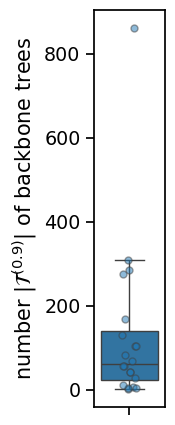

In [104]:
fig, ax = plt.subplots(figsize=(2, 4.5))
ax = sns.boxplot(data=df_ground_truth_tau, ax=ax, y="ell_8", showfliers=False)
sns.stripplot(data=df_ground_truth_tau, ax=ax, y="ell_8", color=sns.color_palette()[0], alpha=.5, linewidth=1)
ax.set_ylabel("number $|\mathcal{T}^{(0.9)}|$ of backbone trees")
plt.tight_layout()
plt.savefig("n8_full_trees.pdf")

/var/folders/_6/xs7jqx4d4_x084c61frqwsrr0000gn/T/ipykernel_38071/3392244569.py:5: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(range(1,9))


Text(0, 0.5, 'approximation ratio')

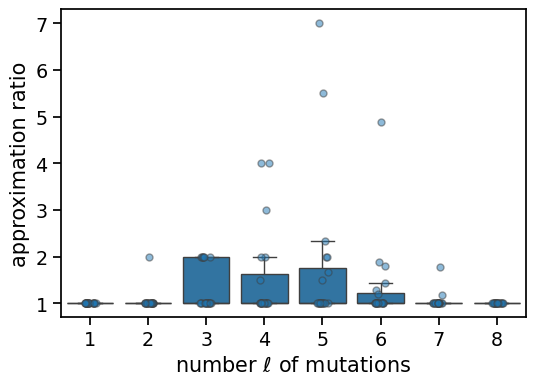

In [105]:
df_melt = df_approx_ratio.melt(var_name="ell",value_name="trees", ignore_index=False)
fig, ax = plt.subplots(figsize=(6, 4))
sns.boxplot(data=df_melt, ax=ax, y="trees", x="ell", showfliers=False)
sns.stripplot(data=df_melt, ax=ax, y="trees", x="ell", color=sns.color_palette()[0], alpha=.5, linewidth=1)
ax.set_xticklabels(range(1,9))
ax.set_xlabel("number $\ell$ of mutations")
ax.set_ylabel("approximation ratio")
# ax.set_ylabel("number $|\mathcal{T}^{(0.9)}|$ of backbone trees")
# plt.tight_layout()
# plt.savefig("n8_full_trees.pdf")

In [153]:
tau1_gt_sol = []
for idx, row in df_ground_truth_tau.iterrows():
    tau1_gt_sol.append(0)
    for ell in range(8):
        if row["ell_%d" % (ell + 1)] == 1:
            tau1_gt_sol[-1] = ell + 1

tau1_sapling_sol = []
for idx, row in df_ground_truth_sapling.iterrows():
    tau1_sapling_sol.append(0)
    for ell in range(8):
        if row["ell_%d" % (ell + 1)] == 1:
            tau1_sapling_sol[-1] = ell + 1

In [152]:
tau1_gt_sol

[7, 2, 2, 4, 5, 3, 4, 7, 5, 2, 4, 3, 2, 7, 6, 1, 3, 6, 5, 6]

In [157]:
for idx in range(20):
    print(" & ".join(map(str, [idx + 1, tau1_gt_sol[idx], 
                               tau1_sapling_sol[idx], "%.2f" %
                               (tau1_sapling_sol[idx] / tau1_gt_sol[idx])])) + "\\\\")

1 & 7 & 7 & 1.00\\
2 & 4 & 2 & 0.50\\
3 & 4 & 2 & 0.50\\
4 & 4 & 4 & 1.00\\
5 & 5 & 5 & 1.00\\
6 & 4 & 3 & 0.75\\
7 & 4 & 4 & 1.00\\
8 & 7 & 7 & 1.00\\
9 & 5 & 5 & 1.00\\
10 & 3 & 2 & 0.67\\
11 & 4 & 4 & 1.00\\
12 & 3 & 3 & 1.00\\
13 & 4 & 2 & 0.50\\
14 & 7 & 7 & 1.00\\
15 & 6 & 6 & 1.00\\
16 & 4 & 1 & 0.25\\
17 & 3 & 3 & 1.00\\
18 & 6 & 6 & 1.00\\
19 & 5 & 5 & 1.00\\
20 & 6 & 6 & 1.00\\
